# 1 Проект `BigData_PySpark`

## 1.1. Название.

Прогнозирование количества заказов такси на следующий час в каждом из округов города Чикаго с помощью **Apache Spark**

## 1.2. Задача проекта.

* Имеется около 10 млн записей о поездках такси в городе Чикаго с округлением времени до 15 минут.   
  Благодарю специалистов **Яндекс.Практикума** за предоставленные датасеты.  
* Задача - предсказать количество заказов на следующий час в каждом округе города.   
* Решаем с применением **'PySpark'** в режиме 'standalone'.  

## 1.3. Описание данных.

В нашем распоряжении данные о поездках в Чикаго за 2022 и 2023 годы.
Описание данных по колонкам:
* `trip_id` - уникальный идентификатор поездки.
* `taxi_id` - уникальный идентификатор машины такси.
* `trip_start_timestamp` - время начала поездки.
* `trip_end_timestamp` - время окончания поездки.
* `trip_seconds` - длительность поездки в секундах.
* `trip_miles` - расстояние поездки в милях.
* `pickup_census_tract` - название зоны посадки.
* `dropoff_census_tract` - название зоны высадки.
* `pickup_community_area` - номер района посадки в Чикаго.
* `dropoff_community_area` - номер района высадки в Чикаго.
* `fare` - стоимость поездки.
* `tips` - чаевые водителю.
* `tolls` - сборы за платные участки дороги.
* `extras` - дополнительные сборы за поездку.
* `trip_total` - общая стоимость поездки.
* `payment_type` - тип оплаты.
* `company` - название компании такси.
* `pickup_centroid_latitude` - географическая широта зоны *посадки*.
* `pickup_centroid_longitude` - географическая долгота зоны *посадки*.
* `pickup_centroid_location` - координаты зоны *посадки*.
* `dropoff_centroid_latitude` - географическая широта зоны *высадки*.
* `dropoff_centroid_longitude` - географическая долгота зоны *высадки*. 
* `dropoff_centroid_location` - координаты зоны *высадки*. 

## 1.4. План работ.

1. Загрузить и изучить данные. 
2. Провести EDA анализ.
3. Провести Feature Engineering.
4. Обучить несколько моделей и сравнить результаты обучения.
5. Сделать сравнение и сформулировать выводы и рекомендации для применения.

# 2. Загрузка и исследование данных.

In [1]:
# !pip install pyspark 
# !pip uninstall findspark==1.4.2 catboost==1.0.3
# !pip install findspark

In [173]:
import os
import findspark
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F


from tqdm.auto import tqdm
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from datetime import timedelta, datetime
from pyspark.sql.functions import (col, lit, isnull, round,
                                   when, count, datediff,
                                   monotonically_increasing_id)

from pyspark.sql.window import Window
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pyspark.ml.regression import (LinearRegression, DecisionTreeRegressor,
                                   RandomForestRegressor, GBTRegressor)
import lightgbm as lgb
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


# Введем глобальную переменные:
RANDOM_FIX_NUMBER = 12345  
NUMBER_CHICAGO_AREAS = 77

# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
# Ограничим ширину отображающихся столбцов
pd.options.display.max_colwidth = 50
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Настроим, чтобы числа в датасетах отражались с 2 знаками после запятой
pd.set_option('display.float_format', '{:.2f}'.format) 

## 2.1.Запуск SPARK-сессии.

In [7]:
findspark.init()

spark = SparkSession.builder.\
        master("local[4]").\
        appName("pyspark-taxi-forecasting").\
        getOrCreate()
# "local[*]" 
spark

Вспомогательные функции:

In [8]:
def format_my(num):
    '''
    Функция установки разделительного знака в виде запятой
    для больших чисел.
    '''    
    return f"{num:,}"

def load_dataset(file_name):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        # Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
        for _ in tqdm(range(1)): 
            data = spark.read.csv(file_name, 
                                  header=True, inferSchema=True)
            print('Dataset', file_name, 'is loaded successfully.')
        # Проверим исходный размер датасетов
        print(f'Количество записей в {file_name}: {format_my(data.count())}\n')
        return data
    else:
        print('Something with', file_name, 'is wrong.')

In [5]:
# Загрузка датасета с данными за 2022 год.
df2022 = load_dataset('Taxi_Trips_-_2022.csv');

# Загрузка датасета с данными за 2023 год.
df2023 = load_dataset('Taxi_Trips_-_2023.csv');

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset Taxi_Trips_-_2022.csv is loaded successfully.
Количество записей в Taxi_Trips_-_2022.csv: 6,382,425



  0%|          | 0/1 [00:00<?, ?it/s]

Dataset Taxi_Trips_-_2023.csv is loaded successfully.
Количество записей в Taxi_Trips_-_2023.csv: 3,783,730



**Промежуточные выводы:**  
В нашем распоряжении 2 датасета с информацией о заказах такси: 
* за 2022 год - 6 382 425 записей,
* за 2023 год - 3 783 730 записей. 

## 2.2.Объединение датасетов.

Прежде, чем провести объединение датасетов, проверим соответствие их признаков.

In [6]:
# Названия колонок в датасете 'df2022':
features2022 = df2022.columns
print(features2022)

# Названия колонок в датасете 'df2023':
features2023 = df2023.columns
print(features2023)

if (features2022 == features2023) :
    print('\nНазвания признаков обоих датасетов одинаковые.')
else:
    print('\nДатасеты имеют разные признаки!.'
          'Cледует изучить возможность их объединения!')

['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']
['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']

Названия признаков обоих датасетов одинаковые.


In [7]:
# Посмотрим данные в df2022
df2022.show(1, vertical=True)

-RECORD 0------------------------------------------
 Trip ID                    | bcfa19f2539021c05... 
 Taxi ID                    | 368ce5511598af2cc... 
 Trip Start Timestamp       | 01/01/2022 12:00:... 
 Trip End Timestamp         | 01/01/2022 12:00:... 
 Trip Seconds               | 152                  
 Trip Miles                 | 0.1                  
 Pickup Census Tract        | NULL                 
 Dropoff Census Tract       | NULL                 
 Pickup Community Area      | NULL                 
 Dropoff Community Area     | NULL                 
 Fare                       | 3.75                 
 Tips                       | 0.0                  
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 3.75                 
 Payment Type               | Cash                 
 Company                    | Medallion Leasin     
 Pickup Centroid Latitude   | NULL                 
 Pickup Cent

In [8]:
df2022.limit(2).toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a2837d021e647f4c8febb3d9bf330e155845b8217b9b451c29b1b9ecf5d55d4bfe6cfd5d79ffb49b1f334,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152,0.10,NaN,NaN,NaN,NaN,3.75,0.00,0.00,0.00,3.75,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e1958f92577ffc9fd6deca97bc1f229d2700865ce12b54d454ba96f973077386210ccbe44bfb7aac317,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360,17.44,NaN,NaN,NaN,8.00,47.75,0.00,0.00,5.00,52.75,Cash,Flash Cab,NaN,NaN,None,41.90,-87.63,POINT (-87.6333080367 41.899602111)


In [9]:
# Посмотрим данные в df2023
df2023.show(1, vertical=True)

-RECORD 0------------------------------------------
 Trip ID                    | 0fca59218b1168827... 
 Taxi ID                    | e2c349c7cbb608d55... 
 Trip Start Timestamp       | 01/01/2023 12:00:... 
 Trip End Timestamp         | 01/01/2023 12:15:... 
 Trip Seconds               | 1037                 
 Trip Miles                 | 4.82                 
 Pickup Census Tract        | NULL                 
 Dropoff Census Tract       | NULL                 
 Pickup Community Area      | 6                    
 Dropoff Community Area     | 32                   
 Fare                       | 15.75                
 Tips                       | 3.25                 
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 19.5                 
 Payment Type               | Credit Card          
 Company                    | Taxicab Insurance... 
 Pickup Centroid Latitude   | 41.944226601         
 Pickup Cent

**Отмечаем**, что признаки в обоих датасетах идентичны, значит, их можно объединять.

In [10]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)): 
    # Объединяем датасеты:
    data = df2022.union(df2023)

    # Проверка, нет ли пропущенных записей после объединения данных:
    if data.count() == df2022.count() + df2023.count():
        print('Данные объединены корректно, потерь нет.')
    else: 
        print('Данные объединены с потерями.')


    # Удалим промежуточные датасеты, чтобы высвободить память:
    del df2022
    del df2023

    full_data_size = data.count()
    print('\nРазмер объединенного датасета:', format_my(full_data_size), 
          'записей на', len(data.columns), 'признака.')

  0%|          | 0/1 [00:00<?, ?it/s]

Данные объединены корректно, потерь нет.

Размер объединенного датасета: 10,166,155 записей на 23 признака.


## 2.3. Приведём все названия колонок к стилю `snakecase`.

In [11]:
print(data.columns)

# Переведём все символы в нижний регистр
# и заменим пробелы на символы подчёркивания:
data = data.toDF(*[c.lower().replace(' ', '_') for c in data.columns])

print(data.columns)

['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']
['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid__location']


**Промежуточные выводы:**   
* Названия признаков приведены к стилю `snakecase`. Теперь к ним можно обращаться через точку.
* Всего 23 признака, из них 8 типа 'string', остальные - числовые.
* Признаки 'trip_start_timestamp' и 'trip_end_timestamp' нужно преобразовать к типу 'дата-время'.
* Для решения поставленной задачи нам нужны всего 2 признака: `trip_start_timestamp` и `pickup_community_area`. Остальные можно удалить.

## 2.4. Удаление ненужных признаков.¶

In [12]:
columns_to_drop = ['trip_id', 'taxi_id', 'trip_end_timestamp', 
                   'trip_seconds', 'trip_miles', 'pickup_census_tract', 
                   'dropoff_census_tract', 'dropoff_community_area', 
                   'fare', 'tips', 'tolls', 'extras', 'trip_total', 
                   'payment_type', 'company', 'pickup_centroid_latitude', 
                   'pickup_centroid_longitude', 'pickup_centroid_location', 
                   'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 
                   'dropoff_centroid__location']
data = data.drop(*columns_to_drop)

print('Признаки, оставленные в датасете:', data.columns)

Признаки, оставленные в датасете: ['trip_start_timestamp', 'pickup_community_area']


## 2.5. Проверка и коррекция типов данных.

In [13]:
print(data.tail(1))
data.printSchema()

# Преобразование к типу 'дата-время'
data = data.withColumn('trip_start_timestamp', 
                       F.to_timestamp(F.col('trip_start_timestamp'),
                       'MM/dd/yyyy hh:mm:ss a'))

# Проверим типы данных
data.printSchema()
print(data.tail(1))

[Row(trip_start_timestamp='08/01/2023 12:00:00 AM', pickup_community_area=34)]
root
 |-- trip_start_timestamp: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)

root
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- pickup_community_area: integer (nullable = true)

[Row(trip_start_timestamp=datetime.datetime(2023, 8, 1, 0, 0), pickup_community_area=34)]


**Отмечаем**:  
признак 'trip_start_timestamp' успешно преобразован к типу 'дата-время'.

## 2.6. Диапазон времени использования такси.

In [14]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    
    date_first = data.select(F.min('trip_start_timestamp')).first()[0]
    date_last = data.select(F.max('trip_start_timestamp')).first()[0]
        
    print('В БД находятся заказы такси, начиная с', 
          date_first, 'и до', date_last, 'продолжительностью', 
          "{} дней.".format((date_last - date_first).days))
    
    print('Количество записей в датасете:', format_my(data.count()))

  0%|          | 0/1 [00:00<?, ?it/s]

В БД находятся заказы такси, начиная с 2022-01-01 00:00:00 и до 2023-08-01 00:00:00 продолжительностью 577 дней.
Количество записей в датасете: 10,166,155


**Отмечаем**, что последний день (2023-08-01) является неполным. Удалим записи за этот день.

In [15]:
# Удаление записей, начиная с '2023-08-01 00:00:00':
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data = data.where(data.trip_start_timestamp<'2023-08-01 00:00:00') 
    
    date_last = data.select(F.max('trip_start_timestamp')).first()[0]
        
    print('В БД находятся заказы такси, начиная с', 
          date_first, 'и до', date_last, 'продолжительностью', 
          "{} дней.".format((date_last - date_first).days))
    
        
    full_data_size = data.count()   
    print('Количество записей в датасете:', format_my(full_data_size))    

  0%|          | 0/1 [00:00<?, ?it/s]

В БД находятся заказы такси, начиная с 2022-01-01 00:00:00 и до 2023-07-31 23:45:00 продолжительностью 576 дней.
Количество записей в датасете: 10,166,125


**Промежуточный результат**:
* Удалены записи за последний неполный день. Количество записей уменьшилось на 30 штук.
* В БД находятся заказы такси продолжительностью 576 дней.

## 2.7. Пропущенные значения.

In [16]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    for feature in data.columns:
        num_null = data[data[feature].isNull()].count()
        print(feature, format_my(num_null))
        
    num_null_area = data[data['pickup_community_area'].isNull()].count()

  0%|          | 0/1 [00:00<?, ?it/s]

trip_start_timestamp 0
pickup_community_area 681,619


**Отмечаем**:
* в признаке 'trip_start_timestamp' нет пропущенных значений.
* в признаке 'pickup_community_area' пропущенных значений много, 681 619.

### 2.7.1. Пропущенные значения в признаке '*pickup_community_area*'.

In [17]:
# Количество значений в столбце `pickup_community_area`
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    community_area_count = data.select('pickup_community_area').\
                           distinct().count()
    print(f'Количество значений в столбце',
          f'`pickup_community_area`: {community_area_count}')

  0%|          | 0/1 [00:00<?, ?it/s]

Количество значений в столбце `pickup_community_area`: 78


**Отмечаем**, что в Чикаго всего 77 городских района. См: [Районы г Чикаго](https://en.wikipedia.org/wiki/Community_areas_in_Chicago "Жми на ссылку...").  
Посмотрим, почему у нас их получается 78?

In [18]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    print("Диапазон значений 'pickup_community_area' от",
          data.select(F.min('pickup_community_area')).first()[0],
          'и до', data.select(F.max('pickup_community_area')).first()[0])

  0%|          | 0/1 [00:00<?, ?it/s]

Диапазон значений 'pickup_community_area' от 1 и до 77


In [19]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    (data.groupby("pickup_community_area").
         agg(F.count("pickup_community_area")).show(15))

  0%|          | 0/1 [00:00<?, ?it/s]

+---------------------+----------------------------+
|pickup_community_area|count(pickup_community_area)|
+---------------------+----------------------------+
|                   31|                       15211|
|                   65|                        3341|
|                   53|                       17653|
|                   34|                       26447|
|                   28|                      873132|
|                   76|                     1736734|
|                   27|                        8206|
|                   26|                        4023|
|                   44|                       44028|
|                   12|                       12810|
|                   22|                       48480|
|                   47|                        2860|
|                 NULL|                           0|
|                    1|                       56517|
|                   52|                        5446|
+---------------------+-----------------------

**Отмечаем**, что в признаке 'pickup_community_area' есть пропуски, соответствующие NULL.

Предположим, что пропуски появились, когда такси работали за пределами города.  

В нашей задаче нужно предсказать количество заказов такси по РАЙОНАМ города, таким образом, пригороды, имеющие огромную территорию, больше, чем городская площадь, в задачу не входят.   

**Принимаем решение** удалить информацию по заказам из пригорода Чикаго.

In [20]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_cleaned = data.na.drop(how='any')

    num_data = data.count()
    num_cleaned_data = data_cleaned.count()
    
    # количество строк до и после удаления пропусков
    print(f'Количество строк до удаления пропусков: {format_my(num_data)}')
    print(f'Количество строк после удаления пропусков: {format_my(num_cleaned_data)}')
    print(f'Удельная часть удаленных записей: ' + 
          f'{(num_data-num_cleaned_data)/num_data:.2%}')
    
    if full_data_size - num_cleaned_data == num_null_area:
        print('\nДанные собраны корректно, потерь нет.')
    else: 
        print('\nДанные имеют потери!')
        
    print('Размер итогового датасета:', f"{format_my(num_cleaned_data)}",
          'записей на', len(data_cleaned.columns), 'признака.') 
    
    # Удалим ненужный более датасет, чтобы высвободить память:
    del data

  0%|          | 0/1 [00:00<?, ?it/s]

Количество строк до удаления пропусков: 10,166,125
Количество строк после удаления пропусков: 9,484,506
Удельная часть удаленных записей: 6.70%

Данные собраны корректно, потерь нет.
Размер итогового датасета: 9,484,506 записей на 2 признака.


## 2.8. Агрегация данных по 1 часу времени заказа.

In [21]:
# Дадим признакам более короткие названия:
data_cleaned = (data_cleaned.
               withColumnRenamed('trip_start_timestamp', 'datetime').
               withColumnRenamed('pickup_community_area', 'area')
               )

data_cleaned.show(100, truncate=False)

+-------------------+----+
|datetime           |area|
+-------------------+----+
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|7   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|77  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|56  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|2   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|22  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|25  |
|

**Отмечаем**, что данные содержат информацию по каждым 15 минутам заказов такси.   

Для нашей задачи нужна информация почасовая, поэтому округлим время до ближайшего часа.

In [22]:
data_cleaned = data_cleaned.withColumn('datetime', 
                                       F.date_trunc('hour', 'datetime'))

data_cleaned.show(100, truncate=False)

+-------------------+----+
|datetime           |area|
+-------------------+----+
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|7   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|77  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|56  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|2   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|22  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|25  |
|

Подсчитаем количество заказов по каждому району Чикаго ежечасно.

In [23]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours = (data_cleaned.
                  groupBy('datetime', 'area').
                  agg(F.count('*').alias('count')).cache()
                 )
    data_hours.show(10)
    
    # Удалим ненужный более датасет, чтобы высвободить память:
    del data_cleaned

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 04:00:00|  14|    2|
|2022-01-01 05:00:00|  22|    3|
|2022-01-01 08:00:00|  28|    3|
|2022-01-01 08:00:00|  39|    1|
|2022-01-01 16:00:00|  44|    1|
|2022-01-01 17:00:00|  36|    4|
|2022-01-01 18:00:00|  13|    1|
|2022-01-02 08:00:00|  77|    4|
|2022-01-02 10:00:00|  48|    1|
|2022-01-02 10:00:00|  34|    2|
+-------------------+----+-----+
only showing top 10 rows



In [24]:
print('Таким образом, за весь период наблюдений у нас собрано',
      format_my(data_hours.count()), 'записей.')
print(date_first)
print(date_last)

print('\nС учетом 24 часа/день и на', NUMBER_CHICAGO_AREAS, 
      'районов города за этот период должно быть собрано',
      "{}".format(format_my((date_last - date_first).days *
                            24 * NUMBER_CHICAGO_AREAS)),
      'записей.')

Таким образом, за весь период наблюдений у нас собрано 606,057 записей.
2022-01-01 00:00:00
2023-07-31 23:45:00

С учетом 24 часа/день и на 77 районов города за этот период должно быть собрано 1,064,448 записей.


**Отмечаем**, что есть очень много пропущенных значений, когда в каком-либо районе Чикаго не было заказов такси!

Отсортируем данные в хронологическом порядке:

In [25]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    print('Исходный датасет:')
    data_hours.sort(['datetime'], ascending = True).show(5)
    
    print('Количество записей в отсортированном датасете:', 
          format_my(data_hours.count()))
    
    print("Диапазон значений 'area' от",
          data_hours.select(F.min('area')).first()[0],
          'и до', data_hours.select(F.max('area')).first()[0])
    
    data_hours.show(5)

  0%|          | 0/1 [00:00<?, ?it/s]

Исходный датасет:
+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 00:00:00|   3|    9|
|2022-01-01 00:00:00|  32|   37|
|2022-01-01 00:00:00|  54|    1|
|2022-01-01 00:00:00|  21|    2|
|2022-01-01 00:00:00|  33|    7|
+-------------------+----+-----+
only showing top 5 rows

Количество записей в отсортированном датасете: 606,057
Диапазон значений 'area' от 1 и до 77
+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 04:00:00|  14|    2|
|2022-01-01 05:00:00|  22|    3|
|2022-01-01 08:00:00|  28|    3|
|2022-01-01 08:00:00|  39|    1|
|2022-01-01 16:00:00|  44|    1|
+-------------------+----+-----+
only showing top 5 rows



**Промежуточные результаты**:
* Подготовлен датасет с признаками:
    * Время заказа такси с дискретностью в 1 час.
    * Номер района Чикаго (в диапазоне от 1 до 77).
    * Количество заказов по данному районе в течение часа.
* Данные отсортированы по времени заявки такси.   

# 3. EDA анализ.

In [26]:
# Посмотрим статистику по количеству заказов по округам и по дате.
data_hours.describe('count').show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            606057|
|   mean|15.649528014691688|
| stddev| 45.44183454171771|
|    min|                 1|
|    max|               591|
+-------+------------------+



**Отмечаем**:
* Диапазон количества заказов по округам и по дате очень широкий: от 1 до 591.
* При значении STD равным 45, есть значения далеко за пределами 3-х сигма, что говорит о наличии аномальных значений.

## 3.1. Распределение заказов такси по различным временным признакам.

In [27]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours = data_hours.withColumn('hour', F.hour('datetime'))
    data_hours = data_hours.withColumn('day_week', F.dayofweek('datetime'))
    data_hours = data_hours.withColumn('day_month', F.dayofmonth('datetime'))
    data_hours = data_hours.withColumn('month', F.month('datetime'))
    
    sort_hour = data_hours.groupby('hour').count().sort('hour').toPandas()
    sort_dayweek = data_hours.groupby('day_week').count().sort('day_week').toPandas()
    sort_daymonth = data_hours.groupby('day_month').count().sort('day_month').toPandas()
    sort_month = data_hours.groupby('month').count().sort('month').toPandas()

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
def visualization_datetime(data, x, x_name):
    plt.figure(figsize=(9, 3))
    sns.barplot(data = data, x = x, y = 'count')
    plt.xlabel(x_name, color = 'blue', size = 10)
    plt.ylabel('Количество заказов такси.', color='blue', size = 10)
    plt.title('Распределение количества заказов такси.',
              color='red', size = 12);

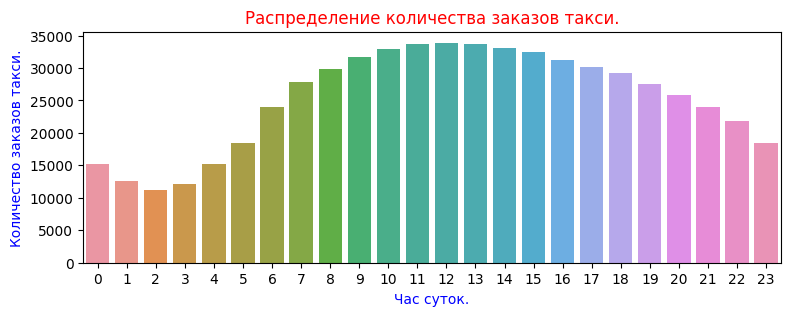

In [29]:
visualization_datetime(sort_hour, 'hour', 'Час суток.')

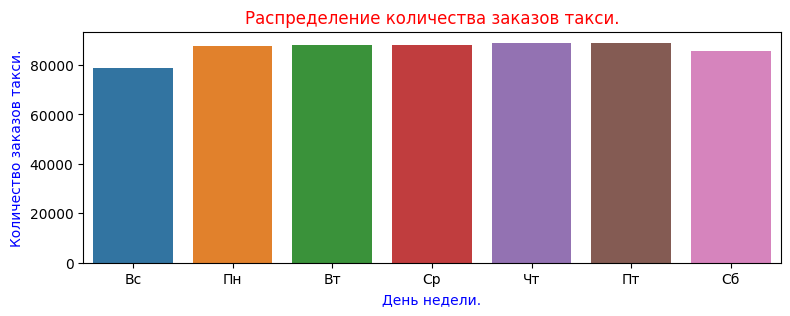

In [30]:
weekdays = ['Вс', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб']
visualization_datetime(sort_dayweek, weekdays, 'День недели.')

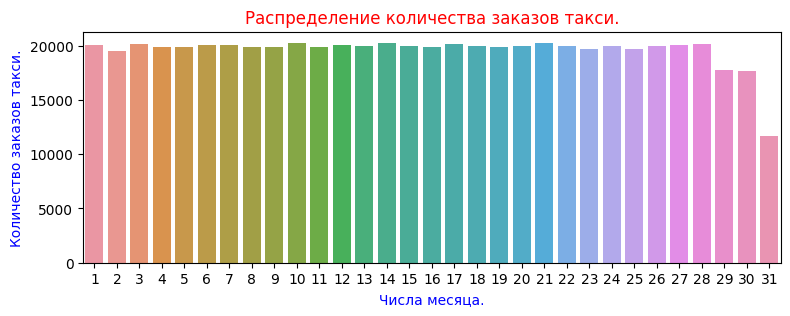

In [31]:
visualization_datetime(sort_daymonth, 'day_month', 'Числа месяца.')

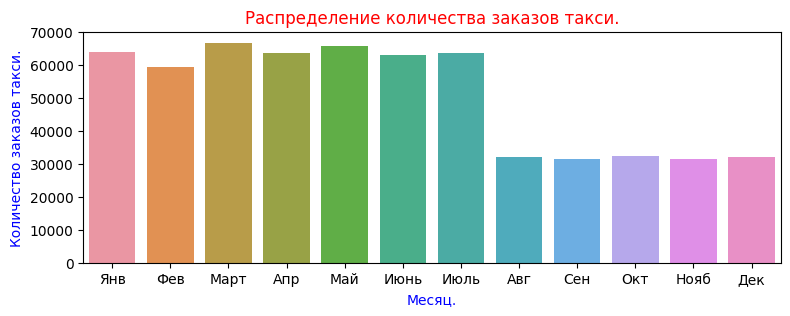

In [32]:
months = ['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 
          'Июль','Авг', 'Сен',  'Окт', 'Нояб', 'Дек']
visualization_datetime(sort_month, months, 'Месяц.')

**Промежуточные выводы**:
* Минимальное количество заказов такси приходится на ночные часы, и максимальное на дневные.
* Количество заказов растет с началом недели до пятницы. В выходние дни такси пользуются реже.
* По дням недели количество заказов довольно ровное. Отметим, что 31 день только примерно в каждом втором месяце.
* Зимой люди реже пользуются такси.

## 3.2. Распределение заказов такси по районам г. Чикаго.

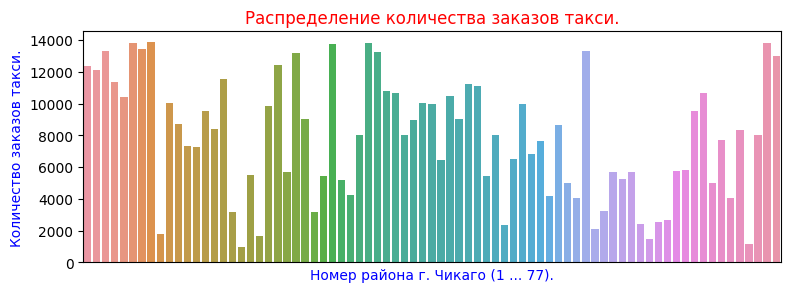

In [33]:
sort_area = data_hours.groupby('area').count().sort('area').toPandas()

plt.figure(figsize=(9, 3))
sns.barplot(data = sort_area, x = 'area', y = 'count')
plt.xlabel(f'Номер района г. Чикаго (1 ... {NUMBER_CHICAGO_AREAS}).', 
           color = 'blue', size = 10)
plt.ylabel('Количество заказов такси.', color='blue', size = 10)
plt.title('Распределение количества заказов такси.',
          color='red', size = 12)
plt.xticks([]);

del sort_area

**Промежуточные выводы**:
* Услугами такси пользуются во всех районах. Но неравномерно.
* Отношение максимального количества заказов к минимальному около 10.

## 3.3. Создание временного ряда с периодом в 1 час без пропущенных значений времени.

In [34]:
# Чтобы видеть, что процесс выполняется, поставим tqdm:
for step in tqdm(range(4)): 
    if step == 0:
        # Создадим переменные типа string: 
        min_date = f"'{date_first.strftime('%Y-%m-%d %H:%M:%S')}'"
        max_date = f"'{date_last.strftime('%Y-%m-%d %H:%M:%S')}'"

        # Создадим последовательность дат с интервалом в 1 час:
        df_1h = spark.range(1).select(
            F.expr(f"sequence(to_timestamp({min_date}), to_timestamp({max_date}), interval 1 hour)").\
            alias("datetime")).selectExpr("explode(datetime) as datetime")
        print('Количество часов в интервале от:', min_date,
              'до', max_date, 'равно:', format_my(df_1h.count()))

    if step == 1:
        # Создадим DataFrame с уникальными номерами городских округов:
        df_num_areas = data_hours.select('area').distinct()
        print('Количество округов в г. Чикаго:', df_num_areas.count())

    if step == 2:    
        # Добавим столбец datetime к каждому округу:
        df_full = df_num_areas.crossJoin(df_1h)
        print('Получили датасет с', format_my(df_full.count()), 'записями.')

    if step == 3:    
        # присоединение агрегированных данных к полному временному ряду
        data_hours_dec = df_full.join(data_hours, ['datetime', 'area'], 'left').\
                                      fillna(0, subset=['count'])
        print('\nСтатистика по полученному датасету:')
        data_hours_dec.describe('count').show()

        # Удалим ненужные df и освободим память:
        del df_1h, df_num_areas, df_full

  0%|          | 0/4 [00:00<?, ?it/s]

Количество часов в интервале от: '2022-01-01 00:00:00' до '2023-07-31 23:45:00' равно: 13,848
Количество округов в г. Чикаго: 77
Получили датасет с 1,066,296 записями.

Статистика по полученному датасету:
+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1066296|
|   mean| 2.222165327451289|
| stddev|17.913053074855817|
|    min|                 0|
|    max|               559|
+-------+------------------+



**Отмечаем**
* количество записей превышает 1 млн. Так и должно быть.
* появились введенные нами записи с нулевым количеством вызванных такси.

## 3.4. Анализ тренда и сезонности.

In [35]:
# Для анализа тренда и сезонности переведём данные в Pandas: 
for_decompose = (data_hours_dec.
                 groupBy('datetime').
                 sum('count').
                 toPandas()
                )
for_decompose.index = for_decompose['datetime']
for_decompose = for_decompose.drop('datetime', axis=1)
for_decompose.sort_index(inplace=True)

df_decompose = for_decompose.resample('1H').sum()

D:\Programs\Anaconda\envs\ds_practicum_env\lib\site-packages\pyspark\sql\pandas\conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


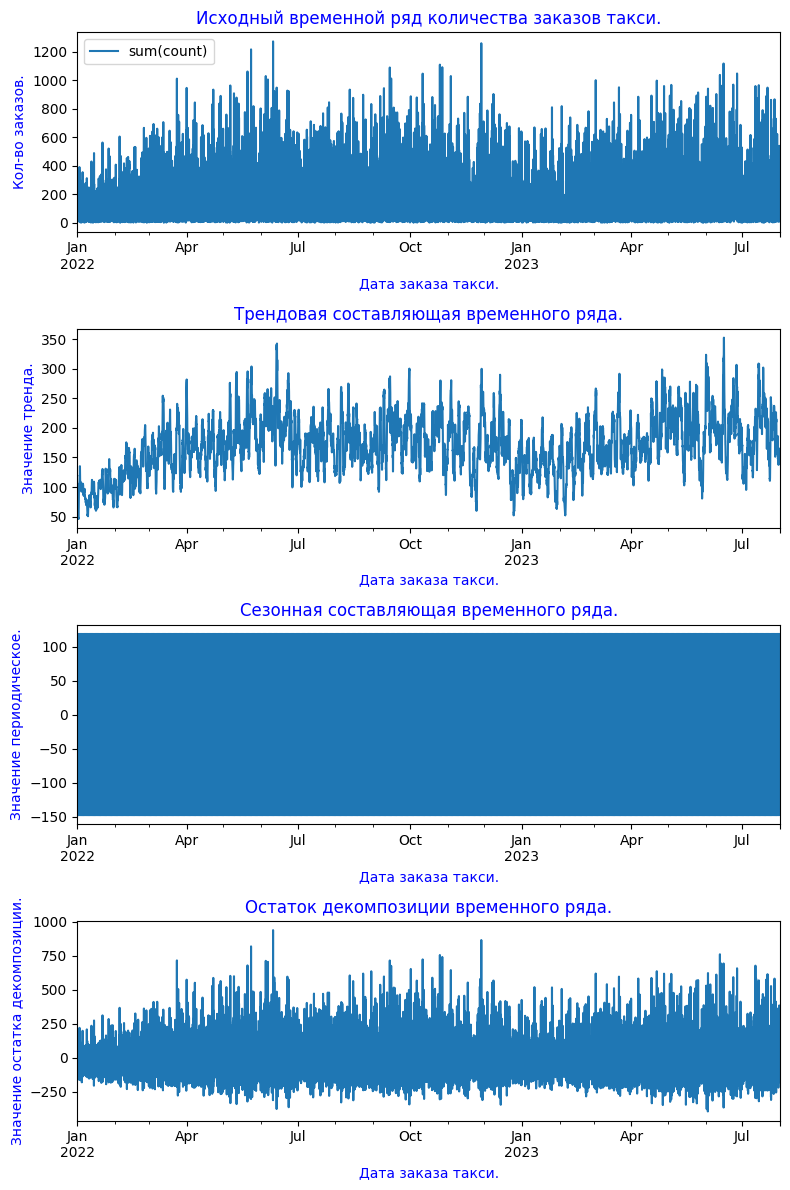

In [36]:
# Разобъём наши данные на три составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(df_decompose)

plt.figure(figsize=(8, 12))

plt.subplot(411)
df_decompose.plot(ax=plt.gca())
plt.title("Исходный временной ряд количества заказов такси.", color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Кол-во заказов.', color = 'blue');

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title("Трендовая составляющая временного ряда.", color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Значение тренда.', color = 'blue');

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Сезонная составляющая временного ряда.", color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Значение периодическое.', color = 'blue');

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title("Остаток декомпозиции временного ряда.", color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Значение остатка декомпозиции.', color = 'blue');

plt.tight_layout()

**Отмечаем**:
* тренд к увеличению заказов такси в летние месяцы с уменьшением заказов зимой,
* сезонность надо посмотреть более тщательно,
* остатки необъяснимы.

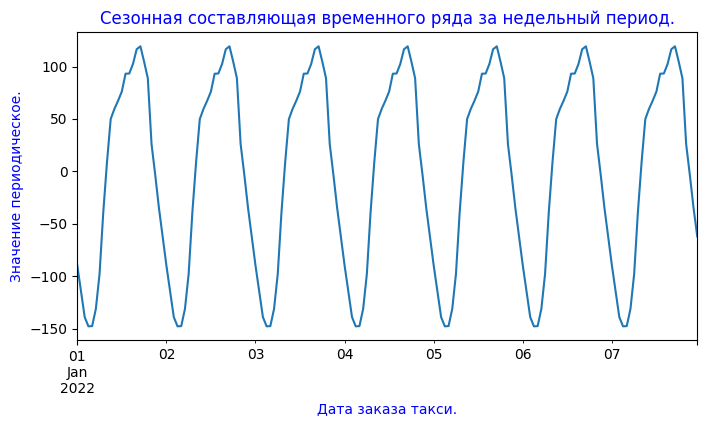

In [37]:
# Изучим сезонную составляющую за неделю
decomposed.seasonal['2022-01-01':'2022-01-07'].plot(figsize=(8, 4));
plt.title("Сезонная составляющая временного ряда за недельный период.", 
          color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Значение периодическое.', color = 'blue');

**Отмечаем** зависимость количества такси от времени суток.

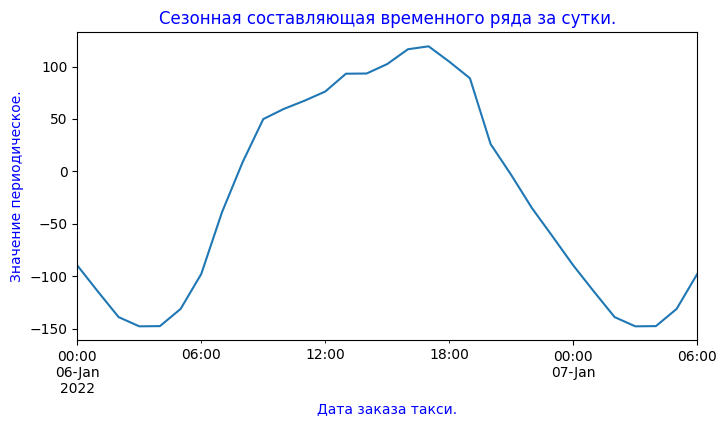

In [38]:
# Изучим сезонную составляющую за сутки
decomposed.seasonal['2022-01-06 00:00:00':'2022-01-07 06:00:00'].plot(figsize=(8, 4));
plt.title("Сезонная составляющая временного ряда за сутки.", 
          color = 'blue')
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.ylabel('Значение периодическое.', color = 'blue');

**Отмечаем**:
* зависимость количества такси от времени суток,
* минимальное количество заказов отмечается в ночное время,
* максимальное количество заказов - в дневное время.

### 3.4.1.  Оценка стационарности временного ряда.

`Стационарность` (stationarity) временного ряда означает, что такие компоненты как `тренд` и `сезонность` отсутствуют. Говоря более точно, среднее значение и дисперсия не меняются со смещением во времени.

#### Метод `скользящего среднего`.

In [39]:
df_decompose.head(3)

,sum(count)
datetime,
2022-01-01 00:00:00,57
2022-01-01 01:00:00,15
2022-01-01 02:00:00,116


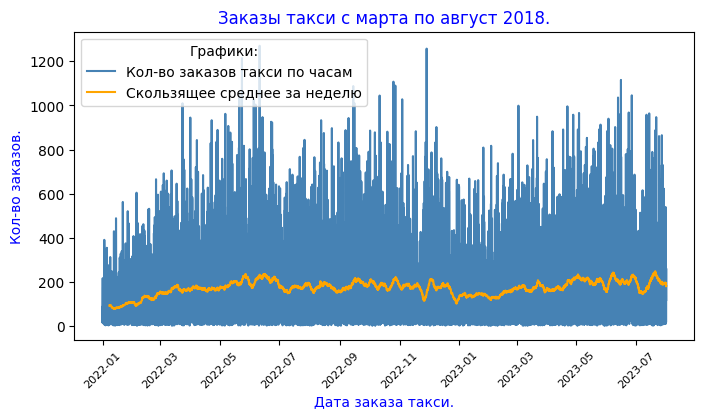

In [40]:
# Зададим признак для рассчитываемых тестовых значений скользящего среднего:


df_decompose['mean'] = df_decompose.rolling(window = 24*7).mean()
# df_decompose['mean'] = df_decompose.rolling(window = 24).mean()

plt.figure(figsize = (8,4))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(df_decompose['sum(count)'], label = 'Кол-во заказов такси по часам', color = 'steelblue')
plt.plot(df_decompose['mean'], label = 'Скользящее среднее за неделю', color = 'orange')
# plt.plot(df_decompose['mean'], label = 'Скользящее среднее за сутки', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = 'Графики:', loc = 'upper left')
 
# добавим подписи к осям и заголовки
plt.xlabel('Дата заказа такси.', color = 'blue')
plt.xticks(fontsize = 8, rotation=45)
plt.ylabel('Кол-во заказов.', color = 'blue')
plt.title('Заказы такси с марта по август 2018.', color = 'blue', fontsize = 12);
 
# выведем обе кривые на одном графике
plt.show()

# Удалим тестовый признак:
df_decompose = df_decompose.drop(columns=['mean'])

**Отмечаем**, что визуальная оценка позволяет судить об отсутствии устойчивого тренда к увеличению количества заказов такси.

### 3.4.2.  Тест `Дики-Фуллера` (Dickey-Fuller test).

Тест заключается в том, что нужно выполнить статистическую проверку следующей гипотезы:
* Нулевая гипотеза предполагает, что процесс нестационарный.
* Альтернативная гипотеза соответственно говорит об обратном. 

Используем пороговые значения, равные 1%, 5% и 10%.

In [41]:
# Передадим функции 'adfuller' данные о количестве заказо такси и
# сохраним результат в переменной adf_test:
adf_test = adfuller(df_decompose['sum(count)'])  
    
print('Критерий ADF: %f' % adf_test[0])    
    
# выведем значение p-value:
print('P-значение: %f' % adf_test[1])  

print('Критические значения:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен") 

Критерий ADF: -12.415117
P-значение: 0.000000
Критические значения:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Промежуточные выводы** по разделу *Анализ тренда и сезонности*:
1. `Тренд` к увеличению заказов такси в летние месяцы с уменьшением заказов зимой.
2. `Сезонность` - зависимость количества заказов такси от времени суток, с максимумом в дневное время и минимумом ночью. Отмечаем максимальный перепад за 6 часов.  
3. Установлена `стационарность` временного ряда. Визуальная оценка **совпала** с математическими вычислениями теста Дики-Фуллера.

In [42]:
# Удалим ненужные df и освободим память:
del for_decompose, df_decompose, decomposed, data_hours_dec

## 3.5. Введём новые признаки.

### 3.5.1. Временные признаки.

In [43]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours = data_hours.withColumn('hour', F.hour('datetime'))
    data_hours = data_hours.withColumn('day_week', F.dayofweek('datetime'))
    data_hours = data_hours.withColumn('day_month', F.dayofmonth('datetime'))
    data_hours = data_hours.withColumn('month', F.month('datetime'))
    
    sort_hour = data_hours.groupby('hour').count().sort('hour').toPandas()
    sort_dayweek = data_hours.groupby('day_week').count().sort('day_week').toPandas()
    sort_daymonth = data_hours.groupby('day_month').count().sort('day_month').toPandas()
    sort_month = data_hours.groupby('month').count().sort('month').toPandas()

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
# Посмотрим наш дата сет
data_hours.show(2)

# Проверим датасет на наличие пропусков:
nacounts = (data_hours.
            select([count(when(isnull(c), c)).alias(c)
                    for c in data_hours.columns]).
            toPandas()
           )
nacounts

+-------------------+----+-----+----+--------+---------+-----+
|           datetime|area|count|hour|day_week|day_month|month|
+-------------------+----+-----+----+--------+---------+-----+
|2022-01-01 04:00:00|  14|    2|   4|       7|        1|    1|
|2022-01-01 05:00:00|  22|    3|   5|       7|        1|    1|
+-------------------+----+-----+----+--------+---------+-----+
only showing top 2 rows



,datetime,area,count,hour,day_week,day_month,month
0,0,0,0,0,0,0,0


**Отмечаем**, что пропусков в датасете нет.

### 3.5.2.  Лаги(отставания).

In [45]:
# окно для разбиения по городским округам и упорядочивания по времени
windowSpec = Window.partitionBy("area").orderBy("datetime")

for lag in range(1, 25):
    data_hours = data_hours.\
                 withColumn('lag_{}h'.format(lag), F.lag('count', lag).\
                 over(windowSpec))

data_hours = data_hours.\
             withColumn("lag_1w", F.lag("count", 24*7).\
             over(windowSpec))

**Отмечаем**, что лаги созданы корректно.

### 3.5.3.  Скользящее среднее.

In [46]:
# В расчет скользящего среднего включаем только значения за предыдущие отрезки времени
window_6h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-7, -1)
window_12h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-13, -1)
window_24h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-25, -1)

data_hours = data_hours.withColumn("rol_6h", F.avg("count").over(window_6h)) \
                       .withColumn("rol_12h", F.avg("count").over(window_12h)) \
                       .withColumn("rol_1d", F.avg("count").over(window_24h)) \
                       .dropna()

**Отмечаем**, что 'скользящее среднее' создано.

### 3.5.4.  Тригонометрическая форма.

In [47]:
# Введём тригонометрические преобразования для временных признаков.
data_hours = (data_hours
   .withColumn("day_sin", F.sin(F.radians(data_hours["hour"] * (360 / 24))))
   .withColumn("day_cos", F.cos(F.radians(data_hours["hour"] * (360 / 24))))
   .withColumn("week_sin", F.sin(F.radians(data_hours["day_week"] * (360 / 7))))
   .withColumn("week_cos", F.cos(F.radians(data_hours["day_week"] * (360 / 7))))
   .withColumn("month_sin", F.sin(F.radians(data_hours["day_month"] * (360 / 30))))
   .withColumn("month_cos", F.cos(F.radians(data_hours["day_month"] * (360 / 30))))
   .withColumn("year_sin", F.sin(F.radians(data_hours["month"] * (360 / 365))))
   .withColumn("year_cos", F.cos(F.radians(data_hours["month"] * (360 / 365))))
    )

**Отмечаем**, что признаки в 'тригонометрической форме' созданы.

In [48]:
data_hours

DataFrame[datetime: timestamp, area: int, count: bigint, hour: int, day_week: int, day_month: int, month: int, lag_1h: bigint, lag_2h: bigint, lag_3h: bigint, lag_4h: bigint, lag_5h: bigint, lag_6h: bigint, lag_7h: bigint, lag_8h: bigint, lag_9h: bigint, lag_10h: bigint, lag_11h: bigint, lag_12h: bigint, lag_13h: bigint, lag_14h: bigint, lag_15h: bigint, lag_16h: bigint, lag_17h: bigint, lag_18h: bigint, lag_19h: bigint, lag_20h: bigint, lag_21h: bigint, lag_22h: bigint, lag_23h: bigint, lag_24h: bigint, lag_1w: bigint, rol_6h: double, rol_12h: double, rol_1d: double, day_sin: double, day_cos: double, week_sin: double, week_cos: double, month_sin: double, month_cos: double, year_sin: double, year_cos: double]

In [68]:
# from pyspark.ml.feature import OneHotEncoder

# features_input = ['hour', 'day_week', 'day_month', 'month']
# features_output= ['hour_ohe', 'day_week_ohe', 'day_month_ohe', 'month_ohe']

# encoder = OneHotEncoder(inputCols = features_input, outputCols= features_output)
# # encoder = OneHotEncoder(inputCols = features_input, outputCol= 'features_ohe')

# model = encoder.fit(data_hours)
# data_hours = model.transform(data_hours)

# # Удалим ненужные features:
# data_hours = data_hours.drop(*features_input)

# # data_hours = encoder.fit(data_hours).transform(data_hours)
# data_hours

# 4. Построение моделей.

Алгоритмы Machine Learning в PySpark принимают на вход только вектора, поэтому нам необходимо предварительно векторизовать данные

In [ ]:
# Сохранение подготовленного датасета.
data_hours.toPandas().to_csv('data_hours.csv', index=False, sep=',') 

In [57]:
# Загрузка подготовленного датасета.
data_hours = load_dataset('data_hours.csv')

# NUMBER_CHICAGO_AREAS = 2 # 11111

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset data_hours.csv is loaded successfully.
Количество записей в data_hours.csv: 593,121



## 4.1. Выделим  `features`.

In [58]:
# Посмотрим типы данных датафрейма:
data_hours

DataFrame[datetime: timestamp, area: int, count: int, hour: int, day_week: int, day_month: int, month: int, lag_1h: int, lag_2h: int, lag_3h: int, lag_4h: int, lag_5h: int, lag_6h: int, lag_7h: int, lag_8h: int, lag_9h: int, lag_10h: int, lag_11h: int, lag_12h: int, lag_13h: int, lag_14h: int, lag_15h: int, lag_16h: int, lag_17h: int, lag_18h: int, lag_19h: int, lag_20h: int, lag_21h: int, lag_22h: int, lag_23h: int, lag_24h: int, lag_1w: int, rol_6h: double, rol_12h: double, rol_1d: double, day_sin: double, day_cos: double, week_sin: double, week_cos: double, month_sin: double, month_cos: double, year_sin: double, year_cos: double]

In [59]:
# from pyspark.ml.feature import MaxAbsScaler
# from pyspark.ml.feature import StandardScaler

# target = 'count' 
features = data_hours.columns[3:] # Исключим 'datetime', 'area', 'count'

# Преобразуем обучающие признаки в вектор:
assembler = VectorAssembler(inputCols=features, outputCol="features") 
data_hours = assembler.transform(data_hours)

# # Приведем вектор с обучающими признаками к диапазону [-1,1] ("scaled_features")
# # путем деления на максимальное абсолютное значение каждого атрибута:
# scaler = MaxAbsScaler(inputCol="features", outputCol="mas_scaled_features")
# scalerModel = scaler.fit(data_hours)
# data_hours = scalerModel.transform(data_hours)

# scaler2 = StandardScaler(inputCol="features", outputCol="st_scaled_features",
#                         withStd=True, withMean=True)
# scalerModel2 = scaler2.fit(data_hours)
# data_hours = scalerModel2.transform(data_hours)

## 4.2. Деление данных на выборки.

In [60]:
# Чтобы видеть, что процесс выполняется, поставим tqdm:
for step in tqdm(range(10)): 
    if step == 0: # Выделим тестовую часть (и для расчёта на неделю)
        last_week = data_hours.filter(F.col("datetime") >= F.lit('2023-07-25'))
    
        date_test_first = last_week.select(F.min('datetime')).first()[0]
        date_test_last = last_week.select(F.max('datetime')).first()[0]
        
        print('Для расчёта заказов на следующей неделе используются',
              'заказы такси с', date_test_first, 'и до', 
              date_test_last, 'продолжительностью', 
              "{} дней.".format((date_test_last - date_test_first).days)) 
        
    if step == 1: # Выделим оставшуюся, после выделения test части
        data_hours =(data_hours.
                     filter( (F.col("datetime") < F.lit('2023-07-25')) &
                           (F.col("datetime") >= F.lit('2022-01-01')))
                    ) 
        
    if step == 2: # Выделим train и valid
        data_hours = data_hours.withColumn('rank', 
                     F.percent_rank().over(Window.orderBy('datetime')))
        train = data_hours.where('rank <= .9').drop('rank')
        valid = data_hours.where('rank > .9').drop('rank')

    if step == 3: # Информация по периоду времени для train выборки
        date_first = train.select(F.min('datetime')).first()[0]
        date_last = train.select(F.max('datetime')).first()[0]
        print('\nОбучение моделей проводится по заказам такси с', 
              date_first, 'и до', date_last, 'продолжительностью', 
              "{} дня.".format((date_last - date_first).days))   
    
    if step == 4: # Информация по периоду времени для valid выборки
        date_first = valid.select(F.min('datetime')).first()[0]
        date_last = valid.select(F.max('datetime')).first()[0]
        print('Валидация моделей проводится по заказам такси с', 
              date_first, 'и до', date_last, 'продолжительностью', 
              "{} дня.".format((date_last - date_first).days))     
        
    if step == 5: # Проверка на потери данных
        if train.count() + valid.count() == data_hours.count():
            print('\nВыборки созданы корректно, потерь нет.')
        else: 
            print('\nВыборки имеют потери!')
            print('Исходное количество записей:', data_hours.count())
            print('Количество записей после разбиения на выборки:', 
                  train.count() + valid.count())
            
    if step == 6: # Информация по train выборке
        print('Размер df_train:', format_my(train.count()), 
              'записей на', len(train.columns), 'признаков.')
        
    if step == 7: # Информация по valid выборке  
        print('Размер df_valid:', format_my(valid.count()),
              'записей на', len(valid.columns), 'признаков.')
        
    if step == 8: # Информация по test/last_week выборке 
        print('Размер  df_test:', format_my(last_week.count()),
              'записей на', len(last_week.columns), 'признаков.')
        
    if step == 9: # Информация по собранным признакам
        print('\nСписок признаков:', train.columns)

# Удалим ненужный датасет, высвободив память:       
del data_hours

df_train, df_valid, df_last_week = [], [], []
for i in range(1, NUMBER_CHICAGO_AREAS+1):
    df_train.append(train.filter(train.area==i))
    df_valid.append(valid.filter(valid.area==i))
    df_last_week.append(last_week.filter(last_week.area==i))   

  0%|          | 0/10 [00:00<?, ?it/s]

Для расчёта заказов на следующей неделе используются заказы такси с 2023-07-25 00:00:00 и до 2023-07-31 23:00:00 продолжительностью 6 дней.

Обучение моделей проводится по заказам такси с 2022-01-08 00:00:00 и до 2023-05-29 21:00:00 продолжительностью 506 дня.
Валидация моделей проводится по заказам такси с 2023-05-29 22:00:00 и до 2023-07-24 23:00:00 продолжительностью 56 дня.

Выборки созданы корректно, потерь нет.
Размер df_train: 527,266 записей на 44 признаков.
Размер df_valid: 58,578 записей на 44 признаков.
Размер  df_test: 7,277 записей на 44 признаков.

Список признаков: ['datetime', 'area', 'count', 'hour', 'day_week', 'day_month', 'month', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_4h', 'lag_5h', 'lag_6h', 'lag_7h', 'lag_8h', 'lag_9h', 'lag_10h', 'lag_11h', 'lag_12h', 'lag_13h', 'lag_14h', 'lag_15h', 'lag_16h', 'lag_17h', 'lag_18h', 'lag_19h', 'lag_20h', 'lag_21h', 'lag_22h', 'lag_23h', 'lag_24h', 'lag_1w', 'rol_6h', 'rol_12h', 'rol_1d', 'day_sin', 'day_cos', 'week_sin', 'week_cos',

## 4.3. Функция для построения модели и расчёта метрик.    

In [61]:
df_scores = pd.DataFrame() 

list_columns = df_valid[0] # Сохраним сптсок обучающих признаков


def calc_model(model):
    '''
    Функция для построения модели и расчёта метрик.
    '''
    score_mae = {}

    for area in tqdm(range(NUMBER_CHICAGO_AREAS)):
        
        model_my = model.fit(df_train[area])            
        predictions = model_my.transform(df_valid[area])
        evaluator = RegressionEvaluator(predictionCol='prediction', 
                                        labelCol='count', metricName='mae')
        score_mae[area] = evaluator.evaluate(predictions)                
        
    df_scores[model.__class__.__name__] = pd.Series(score_mae).describe()
    print(model.__class__.__name__, ': MAE =',
          df_scores[model.__class__.__name__]['mean'])

## 4.4. Модели регрессии для PySpark.

In [62]:
list_models = [
               LinearRegression(
                   featuresCol='features', labelCol='count', 
                   regParam=0.3, elasticNetParam=0.8),
               DecisionTreeRegressor(
                   featuresCol='features', labelCol='count'),
               RandomForestRegressor(
                   featuresCol='features', labelCol='count'),
               GBTRegressor(
                   featuresCol='features', labelCol='count'),    
               ]
    
for mod in list_models:
    calc_model(mod)   

print('\nСтатистика значений MAE по всем моделям:')    
display(df_scores)

  0%|          | 0/77 [00:00<?, ?it/s]

LinearRegression : MAE = 2.276254201781508


  0%|          | 0/77 [00:00<?, ?it/s]

DecisionTreeRegressor : MAE = 2.3083584664803474


  0%|          | 0/77 [00:00<?, ?it/s]

RandomForestRegressor : MAE = 2.2323142538234726


  0%|          | 0/77 [00:00<?, ?it/s]

GBTRegressor : MAE = 2.1009568855465246

Статистика значений MAE по всем моделям:


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GBTRegressor
count,77.00,77.00,77.00,77.00
mean,2.28,2.31,2.23,2.10
std,4.55,5.00,4.72,4.24
min,0.15,0.11,0.13,0.13
25%,0.62,0.56,0.56,0.56
50%,0.86,0.82,0.82,0.81
75%,1.65,1.55,1.56,1.51
max,27.29,30.30,28.83,25.61


In [63]:
# Найдём индекс модели с min значением MAE:
minvalue_index = df_scores.loc['mean'].idxmin()
minvalue = df_scores.loc['mean'].min()

# Найдём порядковый номер лучшей модели в списке моделей:
num = 0
for mod in list_models:
    if minvalue_index == mod.__class__.__name__:
        break
    num += 1    
    
print('Наилучшее значение МАЕ у модели', mod.__class__.__name__,
      'и оно равно', minvalue)

Наилучшее значение МАЕ у модели GBTRegressor и оно равно 2.1009568855465246


**Промежуточные выводы**:
1. Построены модели машинного обучения.
2. Рассчитаны значения MAE по валидационной выборке каждой из моделей.
3. Наилучшее значение МАЕ для модели `GBTRegressor`.

# 5. Построение прогноза на следующую неделю

## 5.1. Расчёт количества заказов такси на следующую неделю:

In [64]:
min_date = f"'{date_test_first.strftime('%Y-%m-%d %H:%M:%S')}'"
max_date = f"'{date_test_last.strftime('%Y-%m-%d %H:%M:%S')}'"

df_res = spark.range(1).select(
    F.expr(f"sequence(to_timestamp({min_date}), to_timestamp({max_date}), interval 1 hour)").\
    alias("datetime")).selectExpr("explode(datetime) as datetime")
print('Количество часов в интервале от:', min_date,
      'до', max_date, 'равно:', df_res.count())


score_mae = {}
predictions = {}
columns=df_train[0].columns[1:]

for area in tqdm(range(NUMBER_CHICAGO_AREAS)):

    model_my = list_models[num].fit(df_train[area])  
    prediction = model_my.transform(df_last_week[area])

    evaluator = RegressionEvaluator(predictionCol='prediction', 
                                    labelCol='count', metricName='mae')
    score_mae[area] = evaluator.evaluate(prediction) 
    
    name_col = 'predict_' + str(area+1)
    prediction = prediction.drop(*columns)
    prediction = prediction.withColumnRenamed('prediction', name_col)
    
    df_res = df_res.join(prediction, ['datetime'], 'left').fillna(0)
      
best_model = 'Best model_' + list_models[num].__class__.__name__ + '_TEST'
df_scores[best_model] = pd.Series(score_mae).describe()
print('Лучшая модель', list_models[num].__class__.__name__, 
      'имеет усредненное по', NUMBER_CHICAGO_AREAS,
      'районам г. Чикаго значение MAE:', df_scores[best_model]['mean'])

display(df_scores)

Количество часов в интервале от: '2023-07-25 00:00:00' до '2023-07-31 23:00:00' равно: 168


  0%|          | 0/77 [00:00<?, ?it/s]

Лучшая модель GBTRegressor имеет усредненное по 77 районам г. Чикаго значение MAE: 1.9549706152650603


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GBTRegressor,Best model_GBTRegressor_TEST
count,77.00,77.00,77.00,77.00,77.00
mean,2.28,2.31,2.23,2.10,1.95
std,4.55,5.00,4.72,4.24,3.86
min,0.15,0.11,0.13,0.13,0.03
25%,0.62,0.56,0.56,0.56,0.54
50%,0.86,0.82,0.82,0.81,0.88
75%,1.65,1.55,1.56,1.51,1.49
max,27.29,30.30,28.83,25.61,24.68


In [66]:
# Сохранение подготовленного датасета.
df_res.toPandas().to_csv('predictions.csv', index=False)
print('Файл сохранен.')

Файл сохранен.


D:\Programs\Anaconda\envs\ds_practicum_env\lib\site-packages\pyspark\sql\pandas\conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [5]:
# Загрузка подготовленного датасета.
local_path = 'predictions.csv' 

if os.path.exists(local_path):
    # Загрузка датасета с данными за 2022 год.
    df_res = load_dataset(local_path);
    print('Local dataset is loaded successfully.')
else:
    print('Something is wrong.')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset predictions.csv is loaded successfully.
Количество записей в predictions.csv: 168

Local dataset is loaded successfully.


In [12]:
df_res.count()

168

## 5.2. Информация по количеству такси на следующую неделю по выбранному округу:

In [197]:
# Введите в список номер региона города Чикаго для просмотра 
# количества такси, необходимых для заказа на ближайшую неделю.

look_areas = [1, 28, 77] # В диапазоне 1...77

for l_area in tqdm(look_areas): # Чтобы видеть, что процесс выполняется
    if l_area not in [i for i in range(1, NUMBER_CHICAGO_AREAS+1)]:
        print('Округ г. Чикаго №', l_area,
             'указан НЕВЕРНО! Пожалуйста, укажите число от 1 до',
              NUMBER_CHICAGO_AREAS, '\n')
        continue 
    
    name_col = 'predict_' + str(l_area)
    df_area = df_res['datetime', name_col]    
    df_area = df_area.sort(['datetime'], ascending = True)
    
    predicts_list = [int(row[name_col]) for row in df_area.collect()]
    
    data = {}
    print('Округ г. Чикаго №', l_area)  
    print('Количество заказываемых такси с интервалом в 1 час:')   
    for i in range(7):
        data['2023-08-0'+str(i+1)] = predicts_list[24*i:24*(i+1)]
    
    df = pd.DataFrame(data)
    df = df.T
    
    name_cols = []
    for i in range(24):
        name_cols.append(str(i)+'-'+str(i+1))
            
    df.columns = name_cols
    display(df)

  0%|          | 0/3 [00:00<?, ?it/s]

Округ г. Чикаго № 1
Количество заказываемых такси с интервалом в 1 час:


,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
2023-08-01,1,0,1,0,0,2,4,6,6,6,7,7,6,7,6,0,5,4,4,3,3,2,2,1
2023-08-02,0,0,1,0,0,2,4,6,6,7,7,7,6,7,6,7,4,5,4,3,3,2,2,1
2023-08-03,1,0,1,1,0,2,4,6,6,6,6,7,6,7,6,7,4,4,4,3,2,2,2,1
2023-08-04,0,0,1,0,1,2,4,6,6,6,6,6,6,6,6,6,5,4,4,3,3,2,2,1
2023-08-05,2,2,2,2,2,2,2,3,3,6,6,5,5,5,5,5,5,5,3,2,0,3,2,2
2023-08-06,2,2,2,2,2,2,0,3,3,3,4,3,4,4,3,4,3,3,4,2,2,2,0,1
2023-08-07,0,1,1,0,0,2,3,6,6,6,6,6,6,6,6,5,5,4,3,3,0,2,2,2


Округ г. Чикаго № 28
Количество заказываемых такси с интервалом в 1 час:


,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
2023-08-01,11,3,3,3,4,9,35,126,235,242,141,112,141,105,114,113,125,135,133,95,64,51,55,29
2023-08-02,13,4,3,3,4,7,37,123,228,244,144,135,152,114,116,122,137,140,141,105,65,60,51,43
2023-08-03,13,4,3,4,4,5,33,121,239,246,144,132,138,130,119,125,139,153,126,96,68,64,57,49
2023-08-04,22,11,3,3,4,5,26,108,202,168,116,110,123,112,107,107,119,115,131,98,67,60,57,54
2023-08-05,58,47,24,5,4,5,3,20,24,56,63,63,74,74,73,75,74,94,62,61,56,54,58,57
2023-08-06,44,43,24,13,4,4,2,15,20,23,51,52,66,58,51,51,33,32,32,31,32,31,28,26
2023-08-07,13,3,3,3,3,6,38,87,165,162,103,110,109,99,99,92,97,105,75,53,47,33,31,26


Округ г. Чикаго № 77
Количество заказываемых такси с интервалом в 1 час:


,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
2023-08-01,2,1,1,1,1,3,6,15,17,16,16,13,15,15,14,12,11,9,8,7,5,5,3,3
2023-08-02,1,1,0,0,0,3,6,15,17,18,14,17,13,14,15,14,10,9,8,6,5,5,3,3
2023-08-03,0,0,1,0,0,3,5,13,16,17,17,17,16,16,16,14,12,10,8,8,7,5,3,3
2023-08-04,2,1,0,1,1,3,6,15,17,18,17,17,16,15,15,14,12,12,10,7,7,5,5,0
2023-08-05,2,2,2,2,0,2,5,7,7,14,16,16,13,13,13,13,13,7,10,10,7,5,5,5
2023-08-06,2,0,0,2,2,2,5,6,7,10,10,10,9,8,8,9,9,6,6,5,5,5,3,3
2023-08-07,2,1,1,1,1,3,6,15,15,17,15,14,15,12,14,14,10,9,8,5,5,5,3,3


## 5.3. Информация по количеству такси по всем округам на указанный час:

In [200]:
def calc_view_taxi_orders(ch_hour):
    '''
    Функция расчёта и вывода на экран таблицы с 
    количеством заказываемых такси.
    '''
    df_hour = df_res.filter(
        (df_res.datetime == (ch_hour - timedelta(days=7))))

    predicts_dict = [row.asDict() for row in df_hour.collect()][0]
    predicts_list = []
    [predicts_list.append(v) for k, v in predicts_dict.items()]

    predicts_list = predicts_list[1:] # уберём поле datetime   

    # Настроим, чтобы числа в датасетах отражались целые числа: 
    pd.set_option('display.float_format', '{:.0f}'.format) 

    print('На', ch_hour, 'в каждом из', NUMBER_CHICAGO_AREAS,
          'округов должно быть заказано указанное в количество такси:')  

    data = {}
    for i in range(7):
        data[i+1] = predicts_list[11*i:11*(i+1)]

    df = pd.DataFrame(data)   

    name_cols = []
    [name_cols.append(str(i*11)+' +') for i in range(7)]  
    df.columns = name_cols

    df = df.T

    name_cols = []
    [name_cols.append(str(i)) for i in range(1,12)]  
    df.columns = name_cols

    display(df)

In [208]:
# Укажем интересующее нас время в диапазоне
# от "2023-08-01 00:00:00" до # "2023-08-07 23:00:00"
choosed_hour = datetime(2023, 8, 5, 18, 0) 

# Выполним проверку правильности указазанной даты:
if choosed_hour < datetime(2023, 8, 1, 0, 0):
    print('Указано неверное время. ДО "2023-08-01 16:00:00".')
elif choosed_hour > datetime(2023, 8, 7, 23, 0):
    print('Указано неверное время. ПОСЛЕ "2023-08-07 23:00:00".')
else:    
    calc_view_taxi_orders(choosed_hour)

На 2023-08-05 18:00:00 в каждом из 77 округов должно быть заказано указанное в количество такси:


,1,2,3,4,5,6,7,8,9,10,11
0 +,4,4,17,4,6,65,48,333,0,0,2
11 +,2,2,2,2,0,0,1,1,1,2,7
22 +,0,27,2,1,1,62,1,0,2,164,49
33 +,3,5,0,3,4,4,0,7,2,4,4
44 +,0,0,0,2,2,0,2,0,2,1,1
55 +,20,0,0,1,1,0,1,0,0,1,0
66 +,1,2,4,1,2,1,2,0,0,195,10


# 6. Выводы.

1. Проведено исследование с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси в г. Чикаго на следующий час. Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.  
2. Исходные данные: набор данных о заказах такси в аэропортах с 2022-01-01 по 2023-08-01. 
3. Для подготовки данных к последующей обработке были проведены следующие операции:  
    * Загрузка файлов с данными 2022 и 2023 годов.
    * Запуск SPARK-сессии.
    * Объединение датасетов.
    * Данные проверены.
    * Выделение нужных признаков.
    * Замена типа данных с `object` на `datetime`.
    * Анализ пропущенных значений и, так как они относятся к загородным поездкам, удаление их.
    * Агрегация данных по 1 часу времени заказа.
    * Данные ресемплированы и расположены в хронологическом порядке.
4. Созданы новые признаки с количеством заказов за:
    * `час`,
    * `день недели`,
    * `день месяца`,
    * `месяц`.  
Изучено распределение заказов такси по этим временным признакам.  
5. Созданы новые признаки :
* `лаги(отставания)`: от 1 до 24 часов и 1 неделя.
* `скользящее среднее`: 6 часов, 12 часов, 1 день.
* `тригонометрические преобразования`: sin и cos для дня, недели, месяца и года. 
6. Исходные данные разделены без перемешивания на обучающую, валидационную и тестовую выборки.
7. Созданы и обучены следующие модели:
    * Линейная регрессия `LinearRegression`.
    * Градиентного бустинга `DecisionTreeRegressor`.
    * Cлучайного леса `RandomForestRegressor`.
    * Градиентного бустинга `GradientBoostingRegressor`.
8. Наилучшей моделью стала `GradientBoostingRegressor` со средним по всем округам значением по тестовой выборке MAE = 1.95.  
9. Специалистам сервиса такси для прогнозирования количества заказов можно рекомендовать использование модели `GradientBoostingRegressor`.
10. Рассчитано количество автомобилей такси, требуемых на ближайшую неделю.

In [209]:
spark.stop()

[Вернутся к общему списку проектов курса Data_Science Яндекс-практикума](../README.md)